# Example: Single Index Model Portfolio Optimization with Risky and Risk-Free Assets
In this example, we'll look at how to implement a single index model (SIM) for portfolio optimization that includes both risky assets and a risk-free asset. 

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> * __Construct capital allocation lines__ using single index models by combining a risky asset portfolio with a risk-free asset, determining optimal capital allocation between risky and risk-free investments for different risk-return preferences.
> * __Compare portfolio optimization approaches__ by computing efficient frontiers for risky-asset-only portfolios versus portfolios that include a risk-free asset, analyzing how the addition of risk-free lending/borrowing expands the investment opportunity set.
> * __Implement SIM-based portfolio optimization__ for risky-only and risky-plus-risk-free cases, understanding how the capital allocation line offers higher returns for any given level of risk compared to the risky-asset-only efficient frontier for investors who can lend or borrow at the risk-free rate.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `10-17-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [2]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 482 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow; # maximum number of trading days in our dataset

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of tickers in our dataset

Next, we'll compute the growth rate matrix for all firms in the dataset. We've implemented [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix) which takes the cleaned dataset and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array.

We'll save this data in the `growth_rate_array::Array{Float64,2}` variable:

In [6]:
growth_rate_array = let

    # initialize -
    r̄ = 0.0; # assume the risk-free rate is 0
    Δt = 1.0/252.0; # assume daily trading (252 trading days in a year)

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = Δt, 
        risk_free_rate = r̄); # other optional parameters are at their defaults

    growth_rate_array; # return
end;

Next, let's load the covariance matrix that we computed in the previous example. We'll store this data in the `covariance_dictionary::Dict{String,Any}` variable:

In [7]:
covariance_dictionary = let

    # initialize -
    path_to_covariance = joinpath(_PATH_TO_DATA,"Covariance-Return-Training-Fall-2025.jld2");
    covariance = JLD2.load(path_to_covariance);
    covariance;
end;

Next, let's load the single asset geometric Brownian motion (SAGBM) parameters, which include the drift and diffusion coefficients for each ticker. We'll store this data in the `parameters_df::DataFrame` variable:

In [8]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

Finally, let's load the single index model parameters that we computed in the previous example. We'll store this data in the `sim_model_parameters::Dict{String,NamedTuple}` variable:

In [9]:
sim_model_parameters, Ḡₘ, Varₘ = let

    # initialize -
    path_to_sim_model_parameters = joinpath(_PATH_TO_DATA,"SIMs-SPY-SP500-01-03-14-to-12-31-24.jld2");
    sim_model_parameters = JLD2.load(path_to_sim_model_parameters);
    parameters = sim_model_parameters["data"]; # return

    Ḡₘ = sim_model_parameters["Ḡₘ"]; # mean of market growth rates
    Varₘ = sim_model_parameters["Varₘ"]; # variance of market growth

    # return -
    parameters, Ḡₘ, Varₘ;
end;

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [10]:
risk_free_rate = 0.0389; # hypothetical continuous compounded risk free rate (units: 1/year)
Δt = (1.0/252.0); # time step for 1-trading day (units: 1/year)

___

## Task 1: Setup Single Index Model Risk and Return Matrices
In this task, we will set up the risk and return matrices that we will use in the minimum variance portfolio allocation. We'll do two versions: one using a pure data driven approach and another using the single index model parameters.

Let's start by specifying a collection of ticker symbols, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers::Array{String,1}` array.

In [11]:
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD","GS", "BAC", "WFC", "C", "F", "GM", 
    "JNJ", "CHD", "PG", "UPS", "COST", "TGT", "WMT"]; # random tickers that I selected.

### SIM-Based Risk and Return Matrices
Now we'll compute the expected return vector and covariance matrix using the single index model. We'll use the SIM formula for expected returns and the SIM-derived covariance structure. Store these in the `μ̂_sim::Array{Float64,1}` and `Σ̂_sim::Array{Float64,2}` variables:

In [12]:
μ̂_sim, Σ̂_sim = let

    # initialize -
    N = length(my_list_of_tickers); # number of assets in portfolio
    μ_sim = Array{Float64,1}(); # drift vector
    Σ̂_sim = Array{Float64,2}(undef, N, N); # covariance matrix for *our* portfolio
    
    # Ḡₘ = mean(Gₘ); # mean of market factor # TODO: already loaded above, we'll use 2014 - 2024 data value
    σ²ₘ = Varₘ; # variance of market factor # TODO: already loaded above, we'll use 2014 - 2024 data value

    # compute the expected growth rate (return) for each of our tickers -
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        data = sim_model_parameters[ticker]; # get the data for this ticker
        αᵢ = data.alpha; # get alpha
        βᵢ = data.beta; # get beta
        Ḡᵢ = αᵢ + βᵢ* Ḡₘ; # compute the growth rate for this ticker
        push!(μ_sim, Ḡᵢ); # append growth rate value to μ_sim
    end

    # compute the covariance matrix using the single index model -
    for i ∈ eachindex(my_list_of_tickers)

        ticker_i = my_list_of_tickers[i];
        data_i = sim_model_parameters[ticker_i]; # get the data for ticker i
        βᵢ = data_i.beta; # get beta for ticker i
        σ²_εᵢ = (Δt)*data_i.training_variance; # residual variance for ticker i

        for j ∈ eachindex(my_list_of_tickers)
            
            ticker_j = my_list_of_tickers[j];
            data_j = sim_model_parameters[ticker_j]; # get the data for ticker j
            βⱼ = data_j.beta; # get beta for ticker j
            σ²_εⱼ = (Δt)*data_j.training_variance; # residual variance for ticker j
            
            if i == j
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ + σ²_εᵢ; # diagonal elements
            else
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ; # off-diagonal elements
            end
        end
    end

    (μ_sim, Σ̂_sim*Δt); # return
end;

## Task 2: Compute the efficient frontiers for your collection of tickers
Now, we'll compute efficient frontiers using the single index model for two cases: risky assets only, and risky assets combined with a risk-free asset. We'll solve the minimum variance problem at multiple return levels to trace out both the risky-only efficient frontier and the capital allocation line.

To begin, create instances of the portfolio optimization problems. Start by setting up the bounds and constants:

In [13]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
max_concentration = 1.0; # maximum concentration allowed in any single asset
wₒ[1] = max_concentration;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= max_concentration; # TODO: Should we allow this upper bound?
risk_free_multiplier = 10.0; # multiplier for risk-free rate (1.0 means we use the risk-free rate as is)
number_of_points = 301; # number of points on the efficient frontier that we want to compute

We need to build two problem objects: one for the risky-asset-only problem using the single index model parameters, and another for the risky-asset plus risk-free asset problem using the single index model estimates. Let's start with the single index model risky-asset-only problem, which we store in the `problem_sim_risky_only` variable:

In [14]:
problem_sim_risky_only = build(MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem, (
    Σ = Σ̂_sim, # sim cov matrix
    μ = μ̂_sim, # sim expected array
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, let's create an instance of [the MyMarkowitzRiskyRiskFreePortfolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyRiskFreePortfolioChoiceProblem) and store this in the `problem_sim_risk_free` variable using our custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyRiskFreePortfolioChoiceProblem},%20NamedTuple}). We pass the covariance array, expected return value, bounds, initial guess, and risk-free rate to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyRiskFreePortfolioChoiceProblem},%20NamedTuple}):

In [15]:
problem_sim_risk_free = build(MyMarkowitzRiskyRiskFreePortfolioChoiceProblem, (
    Σ = Σ̂_sim, # covariance matrix (single index model)
    μ = μ̂_sim, # expected return (single index model)
    bounds = bounds,
    initial = wₒ,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Now that we have both problems set up, we need to create an array with the minimum desired rewards (the calculation must achieve at least this much reward). In this case, assume we go from the risk-free rate to some multiple of the risk-free rate, where we take `number_of_points::Int64` steps.  

We store these values in the `minimum_desired_reward_array::Array{Float64,1}` variable:

In [16]:
minimum_desired_reward_array = range(risk_free_rate, stop = risk_free_multiplier*risk_free_rate, length = number_of_points) |> collect; # range from risk-free rate to 20x risk-free rate

We now iterate through the `minimum_desired_reward_array::Array{Float64,1}` and compute the minimum risk required to achieve the specified reward level using a `for-loop`.

For each pass through the loop, we:
* Update the `problem` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk as the `key` and the expected return, risk and allocation as the `value` in the `efficient_frontier` dictionary.

Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [17]:
efficient_frontier_sim = let

    # initialize -
    efficient_frontier = Dict{Float64, NamedTuple}();

    # main loop
    for i ∈ eachindex(minimum_desired_reward_array)
        problem_sim_risky_only.R = minimum_desired_reward_array[i]; # update the problem object with the min desired reward value
    
        try
            solution = solve(problem_sim_risky_only);
            status_flag = solution["status"];    

            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution["objective_value"]; # get the sqrt of the risk
                reward_value = solution["reward"];
                allocation = solution["argmax"]; # extract the optimal allocation
                efficient_frontier[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            # println("Failed: desired R = $(problem_sim.R). Infeasible");
        end    
    end
    efficient_frontier;
end;

Now compute the capital allocation line by solving the risky-plus-risk-free optimization problem. Store the solutions in the `capital_allocation_line::Dict{Float64,NamedTuple}` dictionary, where the risk variance is the key and a named tuple containing risk, reward, and allocation weights is the value:

In [18]:
capital_allocation_line = let

    capital_allocation_line = Dict{Float64,NamedTuple}();
    for i ∈ eachindex(minimum_desired_reward_array)
    
        # update the problem object -
        problem_sim_risk_free.R = minimum_desired_reward_array[i];
    
        try
            solution_risk_free = solve(problem_sim_risk_free)

            # check: did this converge?
            status_flag = solution_risk_free["status"];    
            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution_risk_free["objective_value"]; # get the sqrt of the risk
                reward_value = solution_risk_free["reward"];
                allocation = solution_risk_free["argmax"]; # extract the optimal allocation
                capital_allocation_line[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            println("Failed: Error: $(err).");
        end
    end
    capital_allocation_line;
end

Dict{Float64, NamedTuple} with 301 entries:
  0.0149042  => (risk = 0.0149042, reward = 0.170771, w = [0.18163, 0.209369, 4…
  0.00246985 => (risk = 0.00246985, reward = 0.092582, w = [0.0739372, 0.085229…
  0.0119068  => (risk = 0.0119068, reward = 0.156767, w = [0.162341, 0.187135, …
  0.00268929 => (risk = 0.00268929, reward = 0.094916, w = [0.0771519, 0.088935…
  9.45451e-5 => (risk = 9.45451e-5, reward = 0.049403, w = [0.0144659, 0.016675…
  0.0114399  => (risk = 0.0114399, reward = 0.154433, w = [0.159127, 0.18343, 5…
  0.00434323 => (risk = 0.00434323, reward = 0.110087, w = [0.0980475, 0.113022…
  0.0795118  => (risk = 0.0795118, reward = 0.343487, w = [0.419517, 0.483588, …
  0.0143813  => (risk = 0.0143813, reward = 0.168437, w = [0.178415, 0.205664, …
  1.20982e-6 => (risk = 1.20982e-6, reward = 0.0400682, w = [0.00157549, 0.0018…
  0.00823589 => (risk = 0.00823589, reward = 0.136928, w = [0.135017, 0.155637,…
  0.0151691  => (risk = 0.0151691, reward = 0.171938, w = [0.1832

Now, let's sort the efficient frontier and capital allocation line data by risk (ascending order) and store the sorted data in an arrays.


> __What are we doing?__ Extract portfolio data from the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary and organize it into the `results_array_data::Array{Float64,2}` matrix. Sort portfolios by risk level and store risk, return, and allocation weights in matrix columns.

> __What's in the results array?__ The `results_array_risky_only::Array{Float64,2}` has `number_of_portfolios::Int64` rows and `M+2` columns:
> * Column 1: Sorted portfolio risk (standard deviation = √variance). Sorted from lowest to highest risk  
> * Column 2: Portfolio expected return
> * Columns 3 to M+2: Asset allocation weights for the `M::Int64` tickers

Let's build the results array for the risky-only portfolios:

In [19]:
results_array_risky_only = let

    # initialize -
    efficient_frontier = efficient_frontier_sim; # use the data efficient frontier
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(my_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array
end

235×20 Matrix{Float64}:
 0.101565  0.0846168  1.97393e-8   2.9855e-8   …   0.0282137    0.19419
 0.101565  0.0846205  1.74676e-8   2.60841e-8      0.0282125    0.194195
 0.101565  0.0846173  7.37819e-7   9.92878e-7      0.0282135    0.19419
 0.101565  0.0846195  7.41863e-7   9.94215e-7      0.0282128    0.194193
 0.101565  0.084617   1.53415e-6   1.49755e-6      0.0282134    0.194189
 0.101565  0.084617   1.53465e-6   1.49787e-6  …   0.0282134    0.194189
 0.101565  0.084617   1.53518e-6   1.4982e-6       0.0282134    0.194189
 0.101565  0.084617   1.53574e-6   1.49852e-6      0.0282134    0.194189
 0.101565  0.084617   1.53632e-6   1.49885e-6      0.0282134    0.194189
 0.101565  0.084617   1.53693e-6   1.49917e-6      0.0282134    0.194189
 ⋮                                             ⋱               
 0.428582  0.302642   0.118049     6.28837e-8     -6.12343e-9  -4.35768e-9
 0.434201  0.303809   0.103313     5.95464e-8     -6.20111e-9  -4.4792e-9
 0.439849  0.304976   0.0885757    

Now, let's do the same for the risky-plus-risk-free portfolios. We'll store the results in the `results_array_risk_free::Array{Float64,2}` variable:

In [20]:
results_array_risk_free = let

    # initialize -
    efficient_frontier = capital_allocation_line; # use the data efficient frontier
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(my_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array
end

301×20 Matrix{Float64}:
 0.000170227  0.0389816  0.000135112  …  9.35312e-5  6.44816e-5  0.000112063
 0.00109992   0.0400682  0.00157549      0.00248492  2.56513e-5  0.000609846
 0.00216144   0.041234   0.00320878      0.00499696  1.29629e-6  0.00104502
 0.00324134   0.042401   0.00482051      0.00750078  2.92796e-7  0.00154316
 0.00432555   0.0435683  0.00641735      0.00999612  5.05582e-6  0.0020861
 0.00540199   0.044735   0.00803561   …  0.0125023   1.46618e-7  0.00256884
 0.00648475   0.0459022  0.00963938      0.0150023   2.8725e-6   0.00309094
 0.0075627    0.047069   0.0112509       0.0175041   9.3319e-8   0.00359362
 0.00864306   0.048236   0.0128584       0.0200049   7.86615e-8  0.0041066
 0.00972343   0.049403   0.0144659       0.0225057   6.79055e-8  0.00461974
 ⋮                                    ⋱                          
 0.31547      0.379664   0.469344        0.730191    4.9206e-8   0.149873
 0.31655      0.380831   0.470952        0.732691    4.90039e-8  0.150387
 0

### Visualize
Now that we have the results arrays for both the risky-only and risky-plus-risk-free portfolios, let's visualize them. We'll create a plot that shows the efficient frontier and the capital allocation line. 

> __What should the plot look like?__ The plot should have risk (standard deviation) on the x-axis and expected return on the y-axis. The efficient frontier should be represented as a curve, while the capital allocation line should be a straight line starting from the risk-free rate and tangent to the efficient frontier at the __tangency portfolio__.

So what do we see?

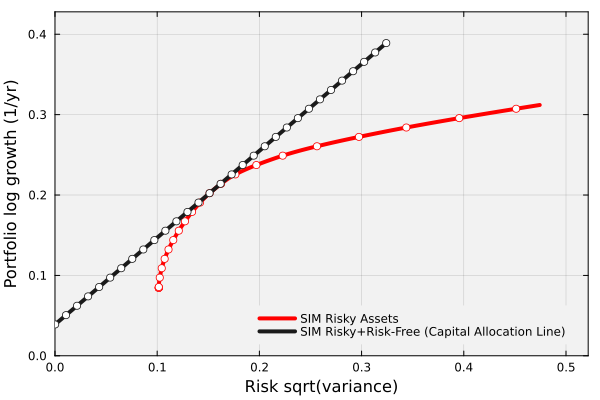

In [21]:
let

    # SIM results: risky-assets only
    max_risk_value_RA = results_array_risky_only[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value_RA = results_array_risky_only[end,2]; # what is the biggest reward that we have (y-axis value)

    max_risk_value_RF = results_array_risk_free[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value_RF = results_array_risk_free[end,2]; # what is the biggest reward that we have (y-axis value)

    max_risk_value = max(max_risk_value_RA, max_risk_value_RF);
    max_reward_value = max(max_reward_value_RA, max_reward_value_RF);

    number_of_portfolios_data = length(efficient_frontier_sim); # how many portfolios did we recover?
    skip = 10;

    plot(results_array_risky_only[:,1], results_array_risky_only[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="SIM Risky Assets", c=:red, 
        xlim=(0.0, 1.1*max_risk_value), ylim = (0.0, 1.1*max_reward_value))
    scatter!(results_array_risky_only[1:skip:number_of_portfolios_data,1], results_array_risky_only[1:skip:number_of_portfolios_data,2], 
        label="", c=:white, ms=4, msc=:red)

    # SIM results: risky-assets + risk-free asset
    number_of_portfolios_data = length(capital_allocation_line); # how many portfolios did we recover?
    skip = 10;
    plot!(results_array_risk_free[:,1], results_array_risk_free[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="SIM Risky+Risk-Free (Capital Allocation Line)", c=:gray10, 
        xlim=(0.0, 1.1*max_risk_value), ylim = (0.0, 1.1*max_reward_value))
    scatter!(results_array_risk_free[1:skip:number_of_portfolios_data,1], results_array_risk_free[1:skip:number_of_portfolios_data,2], 
        label="", c=:white, ms=4, msc=:gray10)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend = :bottomright);
end

### Reflection Questions
Before moving on, consider the following questions:

* __Position on the capital allocation line.__ Consider three positions on the capital allocation line: the y-intercept (pure risk-free), a point halfway to the tangency portfolio, and a point beyond the tangency portfolio. What does each position represent in terms of your investment strategy? How does your exposure to market risk change as you move along this line?

* __Higher expected returns.__ The capital allocation line offers higher expected returns than the risky-asset-only efficient frontier at every level of risk. What economic interpretation explains why adding a risk-free asset creates this improvement? Why would an investor choose a position on the capital allocation line rather than a portfolio on the risky-only frontier?

Now, let's take a look at the performance of the blended portfolios over time. We'll simulate the growth of an investment in the tangency portfolio, an alternative market portfolio, and a pure risk-free investment over the same period.
___

## Task 3: Let's pick a portfolio and see how it performs out-of-sample
In this task, we'll identify the tangency portfolio from the capital allocation line, compute its out-of-sample performance using 2025 data, and compare it to a simple market portfolio strategy (holding `SPY`).

The tangent portfolio is the point on the capital allocation line where the fraction of assets invested in the pool of risky assets is `1`, i.e., all of the investment budget is invested in risky assets. Let's estimate the expected return of the tangent portfolio $\mathcal{P}^{\star}$ using a simple iterative approach.

> __Procedure:__ Let's iterate through the capital allocation line results and compute the fraction in risk assets $\theta$ from the stored allocation. When $\theta \approx 1$, we've found the tangent portfolio. We'll do this using a while-loop and stop when we find the tangent portfolio.

What do we get?

In [22]:
tangent_portfolio_index = let

    # initialize -
    should_stop_loop = false;
    counter = 1;
    θ = 0.0; # fraction in risky assets
    θ_target = 1.0; # threshold for stopping criterion

    while should_stop_loop == false

        w = results_array_risk_free[counter, 3:end]; # extract the allocation
        θ = sum(w); # fraction in risky assets

        if abs(θ - θ_target) < 0.01
            should_stop_loop = true
        end

        counter += 1;
    end

    println("Tangent portfolio found at index = $(counter-1) with θ = $(θ).");
    tangent_portfolio_index = counter - 1; # return
end;

Tangent portfolio found at index = 143 with θ = 0.9962421066688922.


#### What's in the tangent portfolio?
`Unhide` the code block below to see how we constructed the portfolio allocation table for the single-index model tangent portfolio.

> __Summary__: For my choice of tickers, the portfolio allocation problem selected a combination of assets to hold in the tangent portfolio, where the investment budget was unequally divided between the tickers. The overall $\beta$ for the tangent portfolio was greater than the market portfolio, i.e., `SPY.`

Let's build a table to summarize the tangent portfolio allocation:

In [23]:
let

    # initialize -
    w = results_array_risk_free[tangent_portfolio_index, 3:end]; # extract the allocation
    table_df = DataFrame();


    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        wᵢ = w[i];
        row_data = (
            ticker = ticker,
            α = sim_model_parameters[ticker].alpha,
            β = sim_model_parameters[ticker].beta,
            g = μ̂_sim[i],
            w = round(wᵢ, digits=4) |> abs,
        );
        push!(table_df,row_data)
    end

    beta_vec = table_df[:,:β] |> collect;
    alpha_vec = table_df[:,:α] |> collect;
    g_vec = table_df[:,:g] |> collect;
    w_vec = table_df[:,:w] |> collect
    
    # compute the total -
    total = table_df[:,:w] |> sum
    last_row = (
        ticker = "total",
        α = dot(alpha_vec,w_vec),
        β = dot(beta_vec,w_vec),
        g = dot(g_vec,w_vec),
        w = total,
    )
    push!(table_df,last_row)
  
    pretty_table(table_df, backend = :text, fit_table_in_display_vertically = false,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- ------------ ---------- ------------ ---------
  ticker            α          β            g         w 
  String      Float64    Float64      Float64   Float64 
 -------- ------------ ---------- ------------ ---------
    AAPL     0.106055    1.19459     0.232801    0.2282
    MSFT    0.0999256    1.15201     0.222155    0.2631
    INTC    -0.148435    1.18427   -0.0227833       0.0
      MU    -0.053226    1.69527     0.126642       0.0
     AMD     0.127466    1.73915      0.31199     0.049
      GS   -0.0325528    1.31001     0.106439       0.0
     BAC   -0.0545152    1.35942    0.0897199       0.0
     WFC   -0.0914062     1.2383    0.0399782       0.0
       C    -0.133436    1.50075    0.0257945       0.0
       F    -0.192761    1.43356     -0.04066       0.0
      GM    -0.129065     1.4695    0.0268492       0.0
     JNJ   -0.0162091   0.539556    0.0410379       0.0
     CHD    0.0678987    0.35775     0.105856     0.028
      PG    0.0146763    0.49051    0.066719

What's the Sharpe ratio for the tangent portfolio? 

In [24]:
let

    # initialize -
    index_of_portfolio = tangent_portfolio_index + 1; # this should be close to the tangent portfolio index
    w = results_array_risk_free[index_of_portfolio, 3:end]; # extract the allocation
    θ = sum(w); # fraction in risky assets

    # compute the Sharpe ratio -
    reward = results_array_risk_free[index_of_portfolio, 2]; # extract the reward
    risk = results_array_risk_free[index_of_portfolio, 1]; # extract the risk (we already take sqrt)
    sharpe_ratio = (reward - risk_free_rate)/risk;

    # print results -
    println("Portfolio $(index_of_portfolio) has Sharpe ratio = $(round(sharpe_ratio,digits=6)) with θ = $(round(θ,digits=4)).");
end

Portfolio 144 has Sharpe ratio = 1.080178 with θ = 1.0033.


So how does the tangent portfolio perform out-of-sample? Let's use our 2025 data to compute the wealth index for the tangent portfolio and compare it to the market portfolio, e.g., `SPY.`

In [25]:
θ = 0.50; # fraction in risky assets
total_budget = 1000.0; # budget USD invested in a combination of the tangent portfolio and the risk-free asset
budget_in_risky_assets = total_budget*θ; # amount invested in risky assets
budget_in_risk_free_asset = total_budget*(1.0 - θ); # amount invested in risk-free asset

In [26]:
budget_in_risk_free_asset

500.0

Compute the number of shares held in each asset in the tangent portfolio, assuming we invested `budget_in_risky_assets::Float64` USD in the risky assets and `budget_in_risk_free_asset::Float64` USD in the risk-free asset.

In [27]:
nₒ = let

    # initialize -
    portfolio_index = tangent_portfolio_index; # use the tangent portfolio index
    w = results_array_risk_free[portfolio_index, 3:end]; # extract the allocation from the risk-free results array
    n = Array{Float64,1}(undef, length(w)); # number of shares
    B = budget_in_risky_assets; # total budget to invest in risky assets

    for i ∈ eachindex(w)
        ticker = my_list_of_tickers[i];
        price = dataset[ticker][1, :open]; # get the most recent opening price
        dollar_amount = w[i]*B; # dollar amount to invest in this asset
        n[i] = (dollar_amount/price) |> abs; # number of shares to buy (rounded down)
    end

    n; # return the number of shares array
end;

Because we didn't select the tangent portfolio exactly, we may have a small amount of cash left over (or overspent). Let's compute the actual amount invested in the risky assets and risk-free asset (we'll use this value later to compute the wealth index for our alternative portfolio):

In [28]:
actual_invested_budget = let

    S = [dataset[ticker][1, :open] for ticker ∈ my_list_of_tickers]; # extract the price for each ticker on day 1 (opening price)
    dot(S,nₒ) + budget_in_risk_free_asset # total budget invested

end

998.1210533344461

Next, let's compute the number of shares of the alternative market portfolio, e.g., `SPY`, assuming we invested the same total budget of `total_budget::Float64` USD in that asset.

In [29]:
n_alternative = let

    # initialize -
    B = actual_invested_budget; # use the actual invested budget
    ticker = "SPY"; # alternative market portfolio
    price = dataset[ticker][1, :open]; # get the most recent opening price
    n_spy = B/price; # number of shares to buy (rounded down)
    n_spy; # return
end;

Now compute the wealth trajectories for three portfolios: the tangency portfolio mixed with risk-free assets (parameterized by $\theta$), the pure risk-free asset, and the alternative market portfolio (`SPY`). Store these in the `Wₚ::Array{Float64,1}`, `Wᵣ::Array{Float64,1}`, and `Wₐ::Array{Float64,1}` arrays:

In [30]:
Wₚ,Wᵣ,Wₐ = let
    
    # initialize -
    Wₚ = Array{Float64,1}(undef, maximum_number_trading_days); # wealth for our tangent portfolio
    Wᵣ = Array{Float64,1}(undef, maximum_number_trading_days); # wealth for our risk-free asset
    Wₐ = Array{Float64,1}(undef, maximum_number_trading_days); # wealth for our alternative portfolio, e.g., SPY

    for i ∈ 1:maximum_number_trading_days
        
        # Wealth: risk-free asset
        Wᵣ[i] = actual_invested_budget*exp(risk_free_rate*(i*Δt));

        # Wealth: our tangent portfolio -
        Sᵢ = [dataset[my_list_of_tickers[j]][i, :close] for j ∈ eachindex(my_list_of_tickers) ]; # prices at time i
        Wₚ[i] = sum( nₒ[j]*Sᵢ[j] for j ∈ eachindex(my_list_of_tickers) ) + budget_in_risk_free_asset*exp(risk_free_rate*(i*Δt)); # total wealth = risky + risk-free asset

        # Wealth: alternative portfolio, e.g., SPY -    
        Wₐ[i] = n_alternative*dataset["SPY"][i, :close];
    end

    (Wₚ, Wᵣ, Wₐ); # return
end;

Visualize the out-of-sample wealth trajectories for the three portfolios. The plot shows how different capital allocation strategies ($\theta$ values) perform compared to pure risk-free and pure market portfolio strategies:

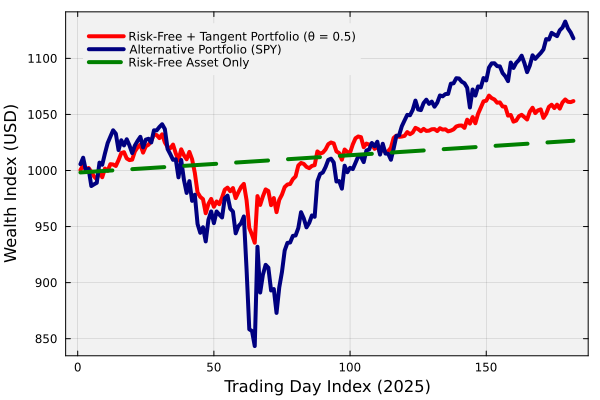

In [31]:
let

    plot(1:maximum_number_trading_days, Wₚ, lw=4, xlabel="Trading Day Index (2025)", 
        ylabel="Wealth Index (USD)", fontsize=18, label="Risk-Free + Tangent Portfolio (θ = $(θ))", c=:red)

    plot!(1:maximum_number_trading_days, Wₐ, lw=4, xlabel="Trading Day Index (2025)", 
        ylabel="Wealth Index (USD)", fontsize=18, label="Alternative Portfolio (SPY)", c=:navy)

    plot!(1:maximum_number_trading_days, Wᵣ, lw=4, xlabel="Trading Day Index (2025)", 
        ylabel="Wealth Index (USD)", fontsize=18, label="Risk-Free Asset Only", c=:green, ls=:dash)


    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

### Reflection Questions
__Increasing $\theta$.__ What happens if we start with $\theta = 0$ (holding only risk-free assets) and progressively increase $\theta$ toward $\theta = 1$ (holding only the tangency portfolio of risky assets)? How do the portfolio's expected return and risk change as we move along this path? What is the economic interpretation of different $\theta$ values in this range?

> __Exercise:__ Test different values of $\theta$ (e.g., $\theta = 0.25, 0.50, 0.75, 1.0$) and observe how the out-of-sample wealth trajectory changes. What trade-offs do you observe between risk and return as $\theta$ increases? At what value of $\theta$ would you be comfortable investing, and why?

___

## Summary
In this example, we extended single index model portfolio optimization to include a risk-free asset, constructing capital allocation lines that offer higher expected returns at every level of risk compared to the risky-asset-only efficient frontier by allowing investors to lend or borrow at the risk-free rate.

> __Key Takeaways:__
> 
> * __Capital allocation line construction:__ We built optimal portfolios combining risky assets and a risk-free asset using SIM parameters, computing the capital allocation line by solving $\min \frac{1}{2}\mathbf{w}^{\top}\mathbf{\Sigma}\mathbf{w}$ subject to $\mathbf{w}^{\top}\boldsymbol{\mu} + (1-\sum_i w_i)r_f = R^*$, where the risk-free weight adjusts to achieve target returns beyond the risky-asset-only frontier.
> * __Efficient frontier comparison:__ We demonstrated that the capital allocation line (with risk-free lending/borrowing) provides higher expected returns than the risky-asset-only efficient frontier at any given risk level, offering superior risk-return combinations by allowing investors to mix the tangency portfolio of risky assets with risk-free positions.
> * __SIM portfolio implementation:__ We applied single index model covariance structure $\operatorname{Cov}(g_i, g_j) = \beta_i\beta_j\sigma_m^2$ for both risky-only and risky-plus-risk-free optimization problems, showing how SIM simplifies portfolio construction while maintaining reasonable approximation of optimal allocations with or without risk-free assets.

The single index model provides an efficient framework for portfolio optimization that extends naturally to include risk-free assets, enabling practical implementation of capital allocation strategies that balance market exposure with risk-free lending or borrowing.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.